In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Загрузите ваши данные
train = pd.read_csv('preprocessing/train_processed.csv')
val = pd.read_csv('preprocessing/val_processed.csv')

print(f"Train shape: {train.shape}")
print(f"Val shape: {val.shape}")
print(f"\nColumns in train: {train.columns.tolist()[:10]}...")  # первые 10 колонок

Train shape: (209107, 144)
Val shape: (52277, 144)

Columns in train: ['children_count', 'income', 'loan_body', 'annuity_payment', 'population_relative_region', 'days_birth', 'days_employed', 'registration_timestamp', 'publication_timestamp', 'age_own_car']...


In [2]:
# 1. Разделите на признаки и целевую переменную
X_train = train.drop(columns=['target'])
y_train = train['target']
X_val = val.drop(columns=['target'])
y_val = val['target']

# 2. Уберите ID если есть
if 'reco_id_curr' in X_train.columns:
    X_train = X_train.drop(columns=['reco_id_curr'])
    X_val = X_val.drop(columns=['reco_id_curr'])

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# 3. Проверьте баланс классов ВАЖНО!
print(f"\nClass distribution in train:")
print(y_train.value_counts(normalize=True).round(4))
print(f"\nClass distribution in val:")
print(y_val.value_counts(normalize=True).round(4))

# 4. Проверьте типы данных
print(f"\nData types in X_train:")
print(X_train.dtypes.value_counts())

# 5. Быстрая проверка на NaN
print(f"\nNaN in X_train: {X_train.isna().sum().sum()}")
print(f"NaN in X_val: {X_val.isna().sum().sum()}")

X_train shape: (209107, 143), y_train shape: (209107,)
X_val shape: (52277, 143), y_val shape: (52277,)

Class distribution in train:
target
0    0.9192
1    0.0808
Name: proportion, dtype: float64

Class distribution in val:
target
0    0.9192
1    0.0808
Name: proportion, dtype: float64

Data types in X_train:
float64    83
bool       60
Name: count, dtype: int64

NaN in X_train: 0
NaN in X_val: 0


BASELINE MODEL: Logistic Regression
ROC-AUC: 0.7427
F1 Score: 0.2546
Precision: 0.1570
Recall: 0.6736

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     48055
           1       0.16      0.67      0.25      4222

    accuracy                           0.68     52277
   macro avg       0.56      0.68      0.53     52277
weighted avg       0.89      0.68      0.75     52277



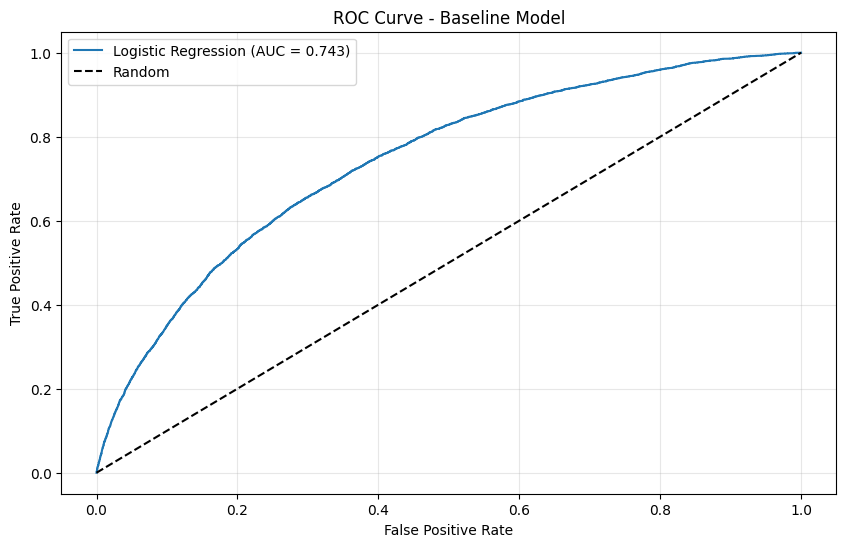

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

# Baseline модель
print("="*50)
print("BASELINE MODEL: Logistic Regression")
print("="*50)

baseline = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # ВАЖНО для несбалансированных данных!
    n_jobs=-1
)

baseline.fit(X_train, y_train)

# Предсказания
y_pred_baseline = baseline.predict(X_val)
y_pred_proba_baseline = baseline.predict_proba(X_val)[:, 1]

# Оценка
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_baseline):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_baseline):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_baseline))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_baseline)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_val, y_pred_proba_baseline):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
from sklearn.ensemble import RandomForestClassifier

print("="*50)
print("RANDOM FOREST (Quick Version)")
print("="*50)

# Быстрый RF с ограниченными параметрами
rf = RandomForestClassifier(
    n_estimators=100,  # ограничиваем для скорости
    max_depth=15,      # ограничиваем глубину
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf.fit(X_train, y_train)

# Предсказания
y_pred_rf = rf.predict(X_val)
y_pred_proba_rf = rf.predict_proba(X_val)[:, 1]

# Оценка
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_rf):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))

RANDOM FOREST (Quick Version)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


ROC-AUC: 0.7399
F1 Score: 0.2796

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     48055
           1       0.19      0.53      0.28      4222

    accuracy                           0.78     52277
   macro avg       0.57      0.67      0.57     52277
weighted avg       0.89      0.78      0.82     52277



XGBOOST (Recommended for Credit Scoring)
[0]	validation_0-logloss:0.67785
[1]	validation_0-logloss:0.66526
[2]	validation_0-logloss:0.65783
[3]	validation_0-logloss:0.64816
[4]	validation_0-logloss:0.64009
[5]	validation_0-logloss:0.63381
[6]	validation_0-logloss:0.62856
[7]	validation_0-logloss:0.62377
[8]	validation_0-logloss:0.61920
[9]	validation_0-logloss:0.61576
[10]	validation_0-logloss:0.61245
[11]	validation_0-logloss:0.60940
[12]	validation_0-logloss:0.60691
[13]	validation_0-logloss:0.60470
[14]	validation_0-logloss:0.60261
[15]	validation_0-logloss:0.60081
[16]	validation_0-logloss:0.59954
[17]	validation_0-logloss:0.59802
[18]	validation_0-logloss:0.59695
[19]	validation_0-logloss:0.59545
[20]	validation_0-logloss:0.59462
[21]	validation_0-logloss:0.59383
[22]	validation_0-logloss:0.59268
[23]	validation_0-logloss:0.59174
[24]	validation_0-logloss:0.59082
[25]	validation_0-logloss:0.58979
[26]	validation_0-logloss:0.58866
[27]	validation_0-logloss:0.58787
[28]	validation_0

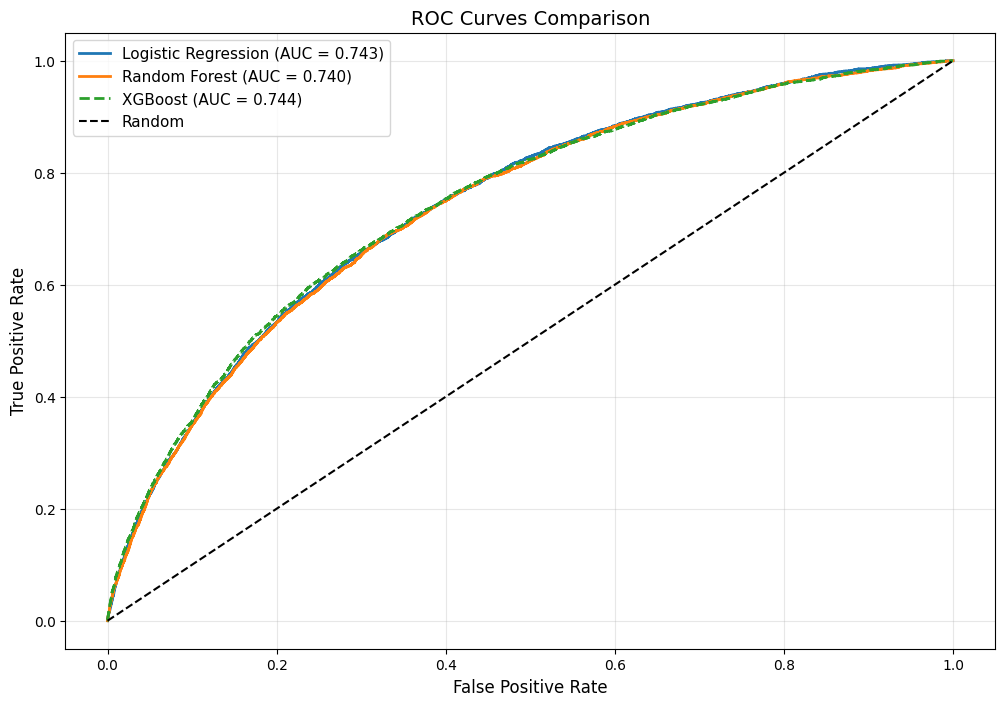

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier

print("="*50)
print("XGBOOST (Recommended for Credit Scoring)")
print("="*50)

# XGBoost с параметрами для несбалансированных данных
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=11.38,  # ВАЖНО: соотношение negative/positive классов (91.92/8.08 ≈ 11.38)
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=1
)

# Обучение с отслеживанием на валидации
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Предсказания
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Оценка
print(f"\nROC-AUC: {roc_auc_score(y_val, y_pred_proba_xgb):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb))

# Сравнение ROC-кривых всех моделей
plt.figure(figsize=(12, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_baseline)
auc_lr = roc_auc_score(y_val, y_pred_proba_baseline)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)
auc_rf = roc_auc_score(y_val, y_pred_proba_rf)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

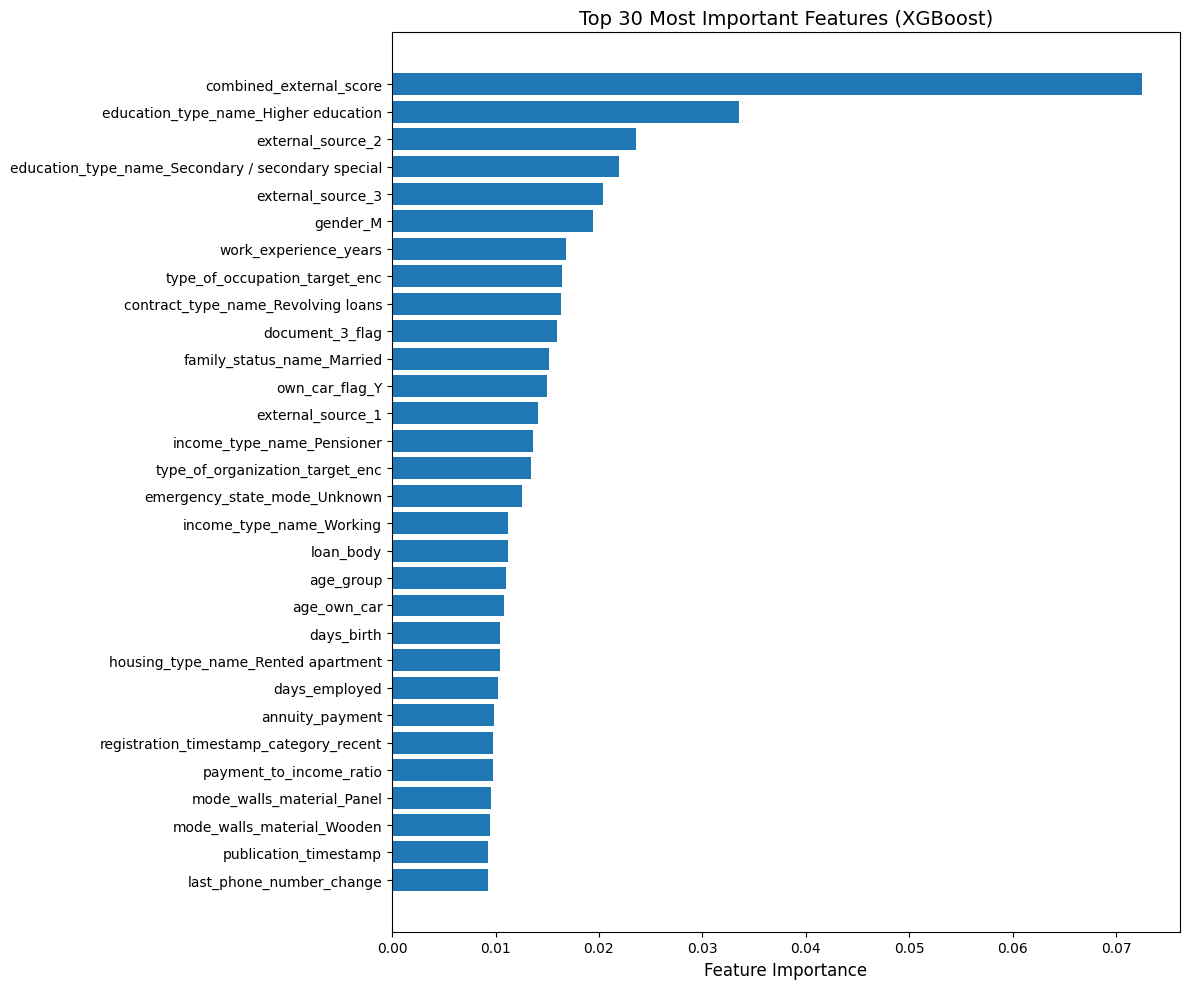

Топ-20 самых важных признаков:
                                               feature  importance
78                             combined_external_score    0.072564
99                education_type_name_Higher education    0.033561
27                                   external_source_2    0.023563
102  education_type_name_Secondary / secondary special    0.021927
28                                   external_source_3    0.020350
82                                            gender_M    0.019405
77                               work_experience_years    0.016857
141                      type_of_occupation_target_enc    0.016403
81                  contract_type_name_Revolving loans    0.016298
50                                     document_3_flag    0.015929
103                         family_status_name_Married    0.015148
84                                      own_car_flag_Y    0.014967
26                                   external_source_1    0.014096
94                          inc

In [6]:
# Feature Importance от XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Топ-30 признаков
plt.figure(figsize=(12, 10))
top_n = 30
top_features = feature_importance.head(top_n)
plt.barh(range(top_n), top_features['importance'])
plt.yticks(range(top_n), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (XGBoost)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Выведите топ-20 признаков для анализа
print("Топ-20 самых важных признаков:")
print(feature_importance.head(20).to_string())

In [7]:
print("="*50)
print("QUICK HYPERPARAMETER TUNING FOR XGBOOST")
print("="*50)

# Ограниченный GridSearch для скорости
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 150],
    'scale_pos_weight': [10, 11.38, 12]  # вес для положительного класса
}

# Создаем GridSearchCV
grid_search = GridSearchCV(
    XGBClassifier(
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    param_grid,
    cv=3,  # 3-fold CV для скорости
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Запускаем поиск (это может занять некоторое время)
grid_search.fit(X_train, y_train)

# Лучшие параметры
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Лучшая модель
best_xgb = grid_search.best_estimator_

# Оценка на валидации
y_pred_best = best_xgb.predict(X_val)
y_pred_proba_best = best_xgb.predict_proba(X_val)[:, 1]

print(f"\nValidation ROC-AUC: {roc_auc_score(y_val, y_pred_proba_best):.4f}")
print(f"Validation F1 Score: {f1_score(y_val, y_pred_best):.4f}")

QUICK HYPERPARAMETER TUNING FOR XGBOOST
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'scale_pos_weight': 10}
Best CV ROC-AUC: 0.7486

Validation ROC-AUC: 0.7508
Validation F1 Score: 0.2717


SHAP ANALYSIS FOR MODEL INTERPRETATION


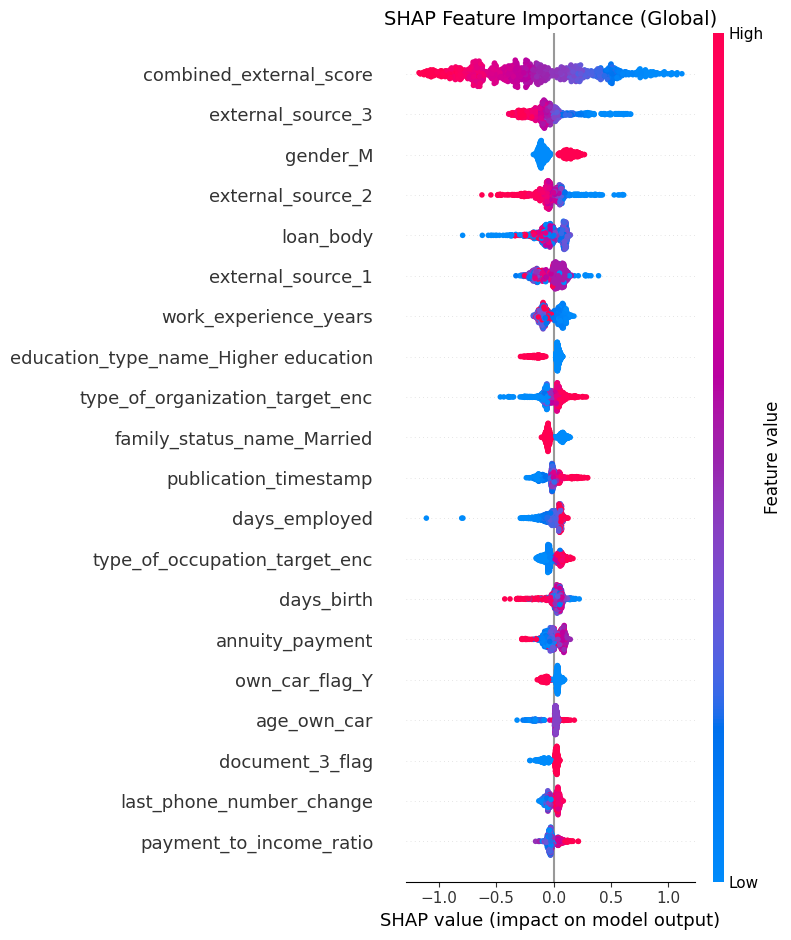

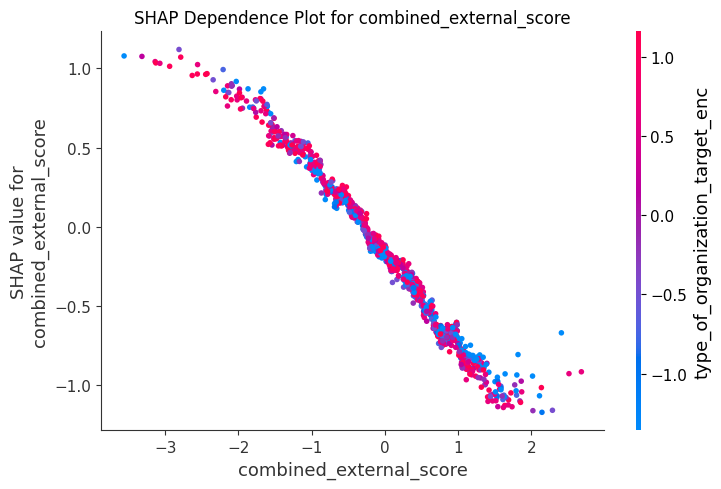

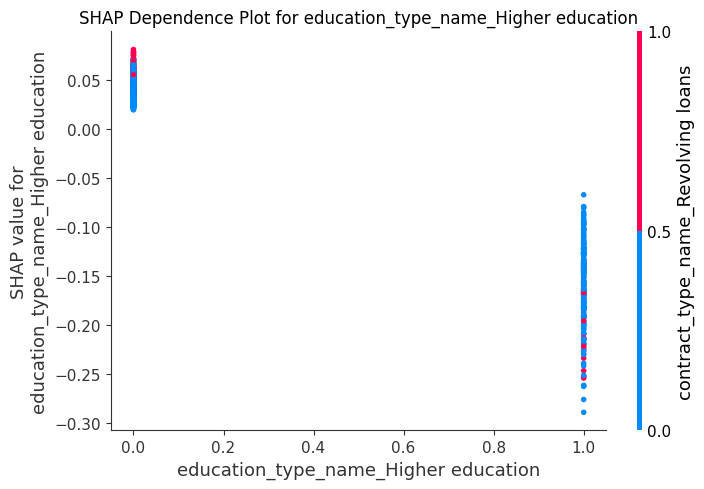

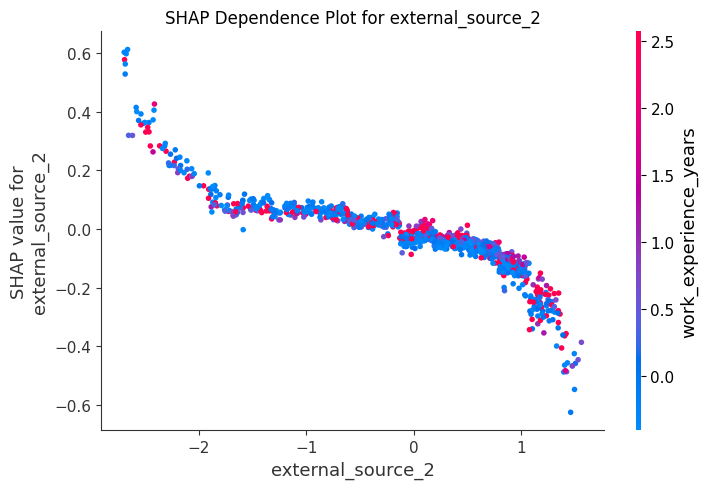


Force plots for individual predictions:

--- Prediction for sample 0 ---
Actual target: 0
Predicted probability: 0.4069


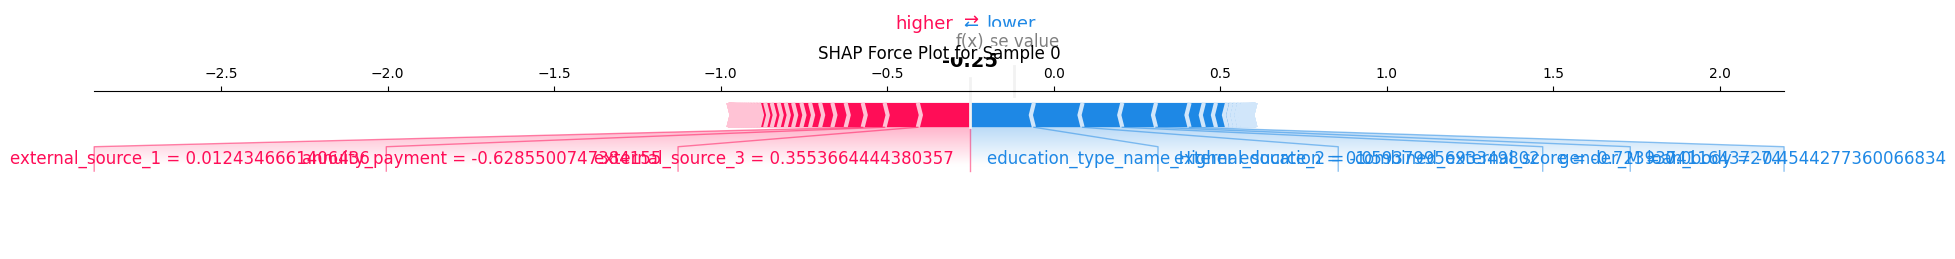


--- Prediction for sample 10 ---
Actual target: 0
Predicted probability: 0.5086


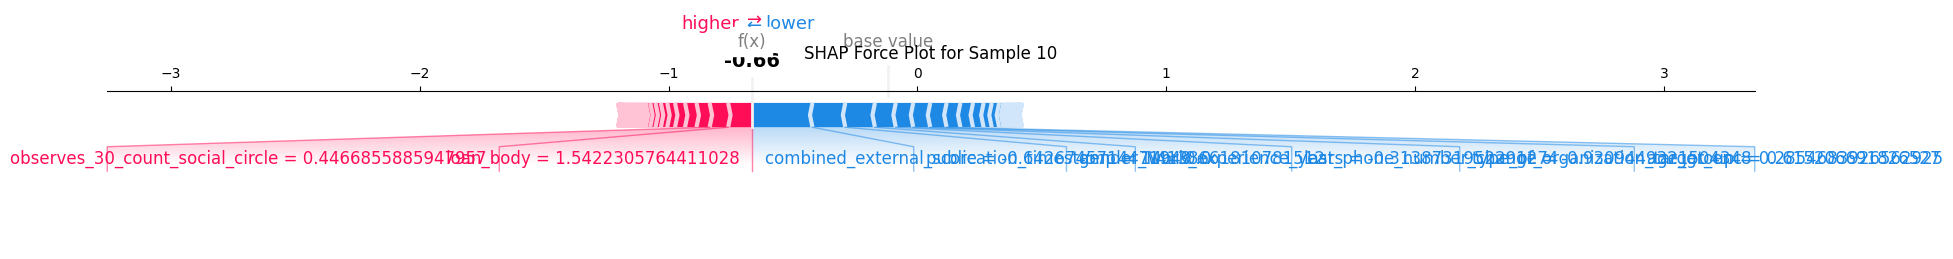


--- Prediction for sample 50 ---
Actual target: 0
Predicted probability: 0.3218


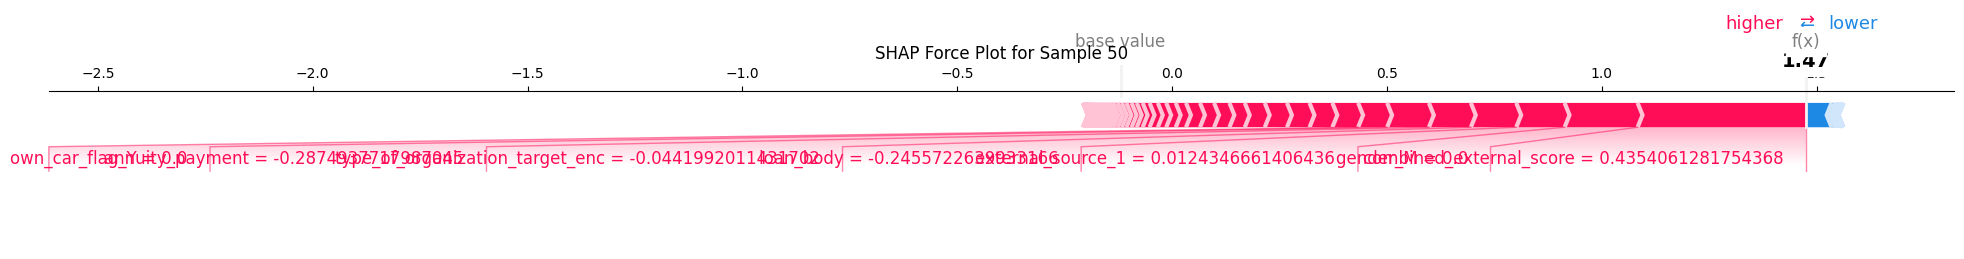

In [8]:
import shap

print("="*50)
print("SHAP ANALYSIS FOR MODEL INTERPRETATION")
print("="*50)

# Инициализируем explainer для XGBoost
explainer = shap.TreeExplainer(best_xgb)  # или xgb_model

# Вычислим SHAP значения для валидационной выборки (возьмем подвыборку для скорости)
sample_idx = np.random.choice(X_val.shape[0], min(1000, X_val.shape[0]), replace=False)
X_val_sample = X_val.iloc[sample_idx]

shap_values = explainer.shap_values(X_val_sample)

# 1. Summary plot (глобальная важность)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val_sample, max_display=20, show=False)
plt.title("SHAP Feature Importance (Global)", fontsize=14)
plt.tight_layout()
plt.show()

# 2. Dependence plot для топ-3 признаков
top_features = feature_importance.head(3)['feature'].tolist()

for feature in top_features:
    if feature in X_val.columns:
        shap.dependence_plot(
            feature, 
            shap_values, 
            X_val_sample,
            display_features=X_val_sample,
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {feature}", fontsize=12)
        plt.tight_layout()
        plt.show()

# 3. Force plot для нескольких примеров
print("\nForce plots for individual predictions:")
sample_cases = [0, 10, 50]  # индексы примеров для анализа

for idx in sample_cases:
    if idx < len(X_val):
        print(f"\n--- Prediction for sample {idx} ---")
        print(f"Actual target: {y_val.iloc[idx]}")
        print(f"Predicted probability: {y_pred_proba_best[idx]:.4f}")
        
        # Force plot
        shap.force_plot(
            explainer.expected_value,
            shap_values[idx],
            X_val.iloc[idx],
            matplotlib=True,
            show=False
        )
        plt.title(f"SHAP Force Plot for Sample {idx}", fontsize=12)
        plt.tight_layout()
        plt.show()

ERROR ANALYSIS


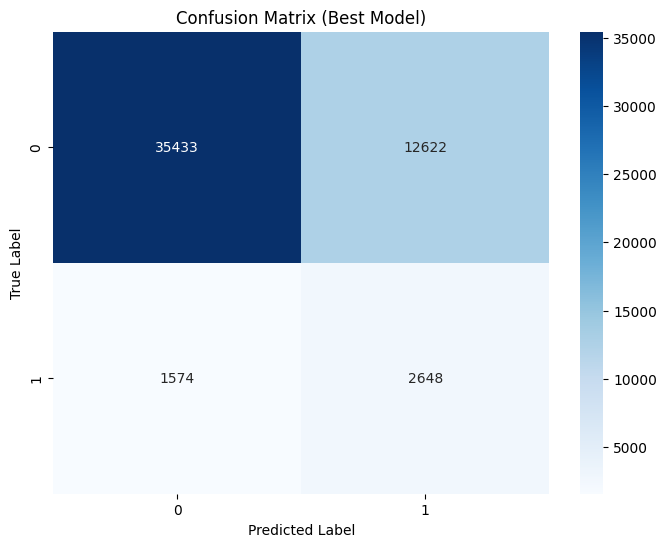

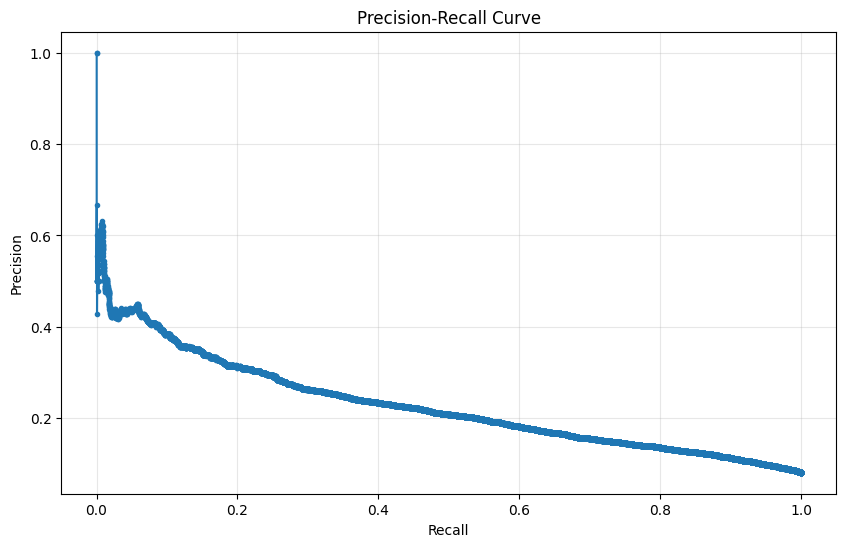

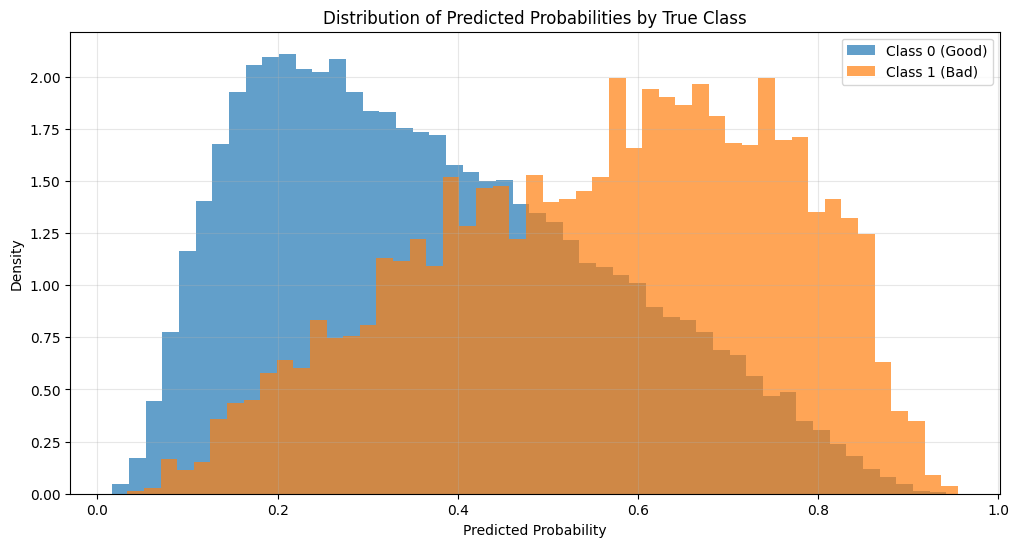

In [9]:
print("="*50)
print("ERROR ANALYSIS")
print("="*50)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Precision-Recall Curve (важно для несбалансированных данных)
precision, recall, _ = precision_recall_curve(y_val, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()

# Анализ распределения вероятностей для разных классов
plt.figure(figsize=(12, 6))
plt.hist(y_pred_proba_best[y_val == 0], bins=50, alpha=0.7, label='Class 0 (Good)', density=True)
plt.hist(y_pred_proba_best[y_val == 1], bins=50, alpha=0.7, label='Class 1 (Bad)', density=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by True Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

FINAL CONCLUSIONS

Model Comparison:
              Model  ROC-AUC  F1-Score  Precision  Recall
Logistic Regression   0.7427    0.2546     0.1570  0.6736
      Random Forest   0.7399    0.2796     0.1898  0.5313
    XGBoost (Basic)   0.7441    0.2695     0.1720  0.6213
    XGBoost (Tuned)   0.7508    0.2717     0.1734  0.6272

TOP 5 BUSINESS-RELEVANT FEATURES:
1. combined_external_score (importance: 0.0726)
2. education_type_name_Higher education (importance: 0.0336)
3. external_source_2 (importance: 0.0236)
4. education_type_name_Secondary / secondary special (importance: 0.0219)
5. external_source_3 (importance: 0.0203)

RECOMMENDED DECISION THRESHOLD ANALYSIS:
Optimal threshold: 0.60
F1-score at optimal threshold: 0.2962
Default threshold (0.5) F1-score: 0.2717


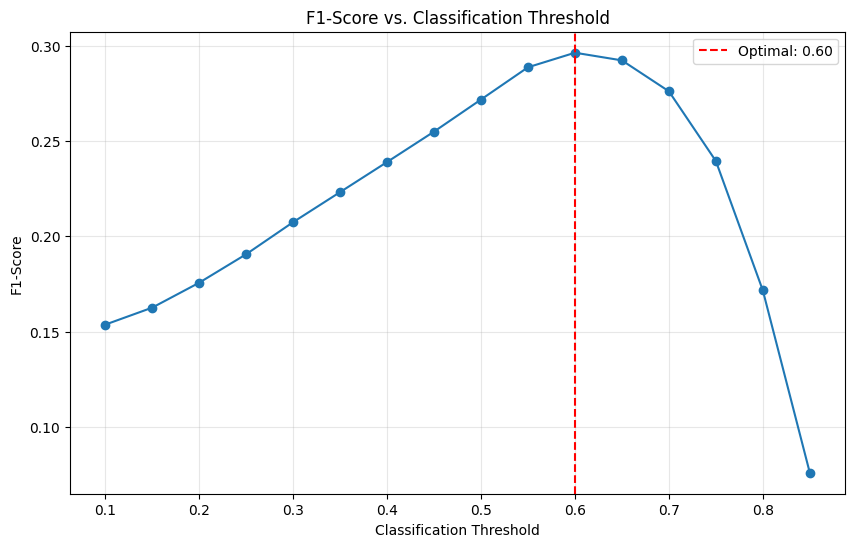

In [10]:
print("="*50)
print("FINAL CONCLUSIONS")
print("="*50)

# Сравнение всех моделей
models = {
    'Logistic Regression': (y_pred_proba_baseline, y_pred_baseline),
    'Random Forest': (y_pred_proba_rf, y_pred_rf),
    'XGBoost (Basic)': (y_pred_proba_xgb, y_pred_xgb),
    'XGBoost (Tuned)': (y_pred_proba_best, y_pred_best)
}

results = []
for name, (proba, pred) in models.items():
    results.append({
        'Model': name,
        'ROC-AUC': roc_auc_score(y_val, proba),
        'F1-Score': f1_score(y_val, pred),
        'Precision': precision_score(y_val, pred),
        'Recall': recall_score(y_val, pred)
    })

results_df = pd.DataFrame(results).round(4)
print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Топ-5 самых важных признаков для бизнес-интерпретации
print("\n" + "="*50)
print("TOP 5 BUSINESS-RELEVANT FEATURES:")
print("="*50)

top_5_features = feature_importance.head(5)
for i, (feature, importance) in enumerate(zip(top_5_features['feature'], top_5_features['importance']), 1):
    print(f"{i}. {feature} (importance: {importance:.4f})")

# Рекомендации по порогу классификации
print("\n" + "="*50)
print("RECOMMENDED DECISION THRESHOLD ANALYSIS:")
print("="*50)

# Найдем оптимальный порог по F1-score
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_best >= threshold).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_thresh))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"F1-score at optimal threshold: {optimal_f1:.4f}")
print(f"Default threshold (0.5) F1-score: {f1_score(y_val, y_pred_best):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal: {optimal_threshold:.2f}')
plt.xlabel('Classification Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Classification Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```
==================================================
Результат на minimal_preprocessing для сравнения
==================================================

Model Comparison:
              Model  ROC-AUC  F1-Score  Precision  Recall
Logistic Regression   0.7449    0.2557     0.1579  0.6720
      Random Forest   0.7323    0.2686     0.1828  0.5057
    XGBoost (Basic)   0.7494    0.2751     0.1754  0.6367
    XGBoost (Tuned)   0.7548    0.2787     0.1783  0.6374

==================================================
TOP 5 BUSINESS-RELEVANT FEATURES:
==================================================
1. external_source_3 (importance: 0.0392)
2. education_type_name_Higher education (importance: 0.0331)
3. external_source_2 (importance: 0.0330)
4. gender_M (importance: 0.0189)
5. income_type_name_Working (importance: 0.0152)

==================================================
RECOMMENDED DECISION THRESHOLD ANALYSIS:
==================================================
Optimal threshold: 0.60
F1-score at optimal threshold: 0.2998
Default threshold (0.5) F1-score: 0.2787
```